In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

# Create data frame populated with CSV data file 
fname_csv = "C:\\ParthaGhosh\\Technical\\MachineLearning\\DataSet\\weatherAUS.csv"
df = pd.read_csv(fname_csv)

# Preprocess fields including dropping unneeded fields and NA rows. 
df = df.drop(['Date', 'Location', 'WindDir9am',
             'WindGustDir', 'WindDir3pm'], axis=1)
df = df.dropna(how = 'any')

# Preprocess fields including categorical to numeric transformation. 
df.loc[df['RainToday'] == 'No', 'RainToday'] = 0
df.loc[df['RainToday'] == 'Yes', 'RainToday'] = 1

In [39]:
# Create features and labels 
X,y = df.drop('RainTomorrow',axis=1,inplace=False), df[['RainTomorrow']]

# Convert X series into Z transform and tensor
std_scalar = StandardScaler()
X_scaled = std_scalar.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)

# Convert y series into label and tensor
l_enc = LabelEncoder()
y_numerical = l_enc.fit_transform(y.values.ravel())

## AutoEncoder Class follows. 

In [40]:
class Autoencoder(nn.Module):
    
    def __init__(self, dim_inp, dim_enc):
        
        # Calling super initialization 
        super(Autoencoder, self).__init__()
        
        # Define encoder 
        self._enc = nn.Sequential(
            nn.Linear(dim_inp,16),
            nn.ReLU(),
            nn.Linear(16,dim_enc), 
            nn.ReLU()
        )
                
        # Define Decoder 
        self._dec = nn.Sequential(
            nn.Linear(dim_enc,16),
            nn.ReLU(),
            nn.Linear(16,dim_inp), 
            nn.Sigmoid()
        )
        pass
    
    def forward(self,x):
        x = self._enc(x)
        x = self._dec(x)
        return x

    
    
    pass 

## Training Loop begins.

In [41]:
# Define a random seed for reproducibility. 
seed = 42 
torch.manual_seed(seed)

# Extract input dimension 
dim_inp = X.shape[1]

# Define Encoder dimension 
dim_enc = 3

# Define model now. 
model = Autoencoder(dim_inp, dim_enc)

# Define loss criterion 
criterion = nn.MSELoss() 

# Define optimizer 
optimizer_obj = optim.Adam(model.parameters(),lr=0.003)

# number of epochs 
num_epochs = 20

# Training loop begins 
for an_epoch in range(num_epochs):
    
    # orward pass
    output = model.forward(X_tensor)
    
    # Compute loss
    loss = criterion(output,X_tensor)
    
    # Initialize Optiizer, Backpropagate loss, and Update Parameters 
    optimizer_obj.zero_grad() 
    loss.backward()
    optimizer_obj.step()
    
    # Print loss 
    print(f"Epoch: {an_epoch}/{num_epochs} ----> Loss:{loss.item():.4f}") 

Epoch: 0/20 ----> Loss:1.2443
Epoch: 1/20 ----> Loss:1.2410
Epoch: 2/20 ----> Loss:1.2376
Epoch: 3/20 ----> Loss:1.2342
Epoch: 4/20 ----> Loss:1.2307
Epoch: 5/20 ----> Loss:1.2271
Epoch: 6/20 ----> Loss:1.2234
Epoch: 7/20 ----> Loss:1.2196
Epoch: 8/20 ----> Loss:1.2156
Epoch: 9/20 ----> Loss:1.2114
Epoch: 10/20 ----> Loss:1.2070
Epoch: 11/20 ----> Loss:1.2023
Epoch: 12/20 ----> Loss:1.1974
Epoch: 13/20 ----> Loss:1.1923
Epoch: 14/20 ----> Loss:1.1868
Epoch: 15/20 ----> Loss:1.1811
Epoch: 16/20 ----> Loss:1.1751
Epoch: 17/20 ----> Loss:1.1688
Epoch: 18/20 ----> Loss:1.1622
Epoch: 19/20 ----> Loss:1.1554


## Encode a test vector using the trained model. 

In [42]:
# Let us use the created tensor, X_tensor, itself. 

# The following line also works.
# X_enc_tensor = model._enc(X_tensor) 
X_enc_tensor = model._enc(X_tensor).detach().numpy()

X_enc_tensor.shape

(58090, 3)

## Visualize Encoded vectors

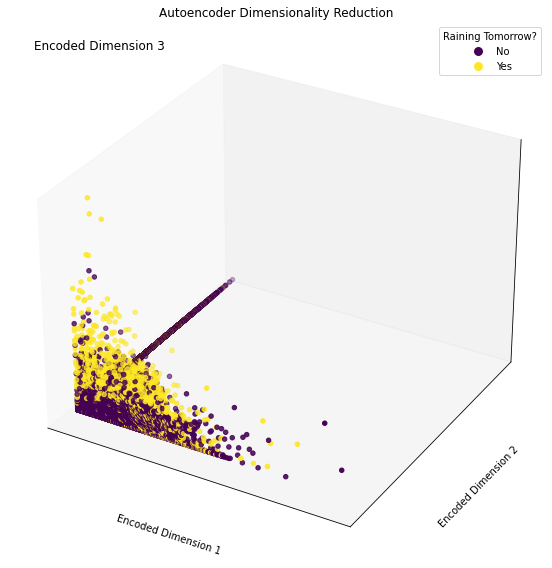

In [43]:
# Plotting the encoded data in 3D space
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_enc_tensor[:, 0], X_enc_tensor[:, 1],
                    X_enc_tensor[:, 2], c=y_numerical, cmap='viridis')

# Mapping numerical labels back to original string labels for the legend
labels = l_enc.inverse_transform(np.unique(y_numerical))
legend_labels = {num: label for num, label in zip(np.unique(y_numerical),
                                                 labels)}

# Creating a custom legend with original string labels
handles = [plt.Line2D([0], [0], marker='o', color='w',
                    markerfacecolor=scatter.to_rgba(num),
                    markersize=10,
                    label=legend_labels[num]) for num in np.unique(y_numerical)]
ax.legend(handles=handles, title="Raining Tomorrow?")

# Adjusting the layout to provide more space for labels
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Manually adding z-axis label for better visibility
ax.text2D(0.05, 0.95, 'Encoded Dimension 3', transform=ax.transAxes,
         fontsize=12, color='black')

ax.set_xlabel('Encoded Dimension 1')
ax.set_ylabel('Encoded Dimension 2')
ax.set_title('Autoencoder Dimensionality Reduction')

plt.tight_layout()

save_dir="output"
save_file = save_dir+"\\Rain_Prediction_Autoencoder.png"
plt.savefig(save_file)

plt.show()